# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 2

# Preliminary operations 

In [27]:
# import needed python libraries

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [17]:
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0)
conteggio = len(ddos_data.loc[ddos_data['SimillarHTTP'] == '0'])
print(conteggio)
print("--------------")

63761
--------------


/var/folders/zt/bp4qnl8d1zq30854_2rkq73w0000gn/T/ipykernel_89291/2304401882.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")


# 1. Perform a split to segment the dataset into training and test dataset, in a stratified way with respect to the labels

In [48]:
# Prepare the dataset extracting Features (X) and Labels (Y) 
# Stratify the dataset by having 70% of the data in the traning set and 30% in the test set
ddos_data_copy = ddos_data.copy()

ddos_data_copy['label'] = pd.Categorical(ddos_data_copy['label']).codes # transform to numerical labels
ddos_data_copy.drop(columns=["Unnamed: 0","Flow ID","Destination IP","Source IP","Timestamp","SimillarHTTP"],axis=1,inplace=True)

x = ddos_data_copy.drop(columns=['label']).to_numpy()
y = ddos_data_copy[['label']].to_numpy()

# Run stratified training-test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.7, random_state=15)


# This line is used to flatten the labels (which might be in a two-dimensional array) into one-dimensional arrays. 
# This is often necessary for compatibility with certain machine learning algorithms that expect 1D arrays for labels.

y_train, y_test = np.ravel(y_train), np.ravel(y_test)

# Standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_s, x_test_s = scaler.transform(x_train), scaler.transform(x_test)

# 2. Choose at least 3 ML methods, and perform the model training, with default parameter configuration, evaluating the performance on both training and test set. Output the confusion matrix and classification report. Do you observe overfitting or under-fitting? 

In [41]:
# MODELS TRAINING


# Initialize the models with default parameters
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(random_state=0)
logistic_regression = LogisticRegression(random_state=0)

# Train the models on the training data
decision_tree.fit(x_train_s, y_train)
random_forest.fit(x_train_s, y_train)
logistic_regression.fit(x_train_s, y_train)

# Evaluate the models on the training set
y_train_pred_dt = decision_tree.predict(x_train_s)
y_train_pred_rf = random_forest.predict(x_train_s)
y_train_pred_lr = logistic_regression.predict(x_train_s)

# Evaluate the models on the test set
y_test_pred_dt = decision_tree.predict(x_test_s)
y_test_pred_rf = random_forest.predict(x_test_s)
y_test_pred_lr = logistic_regression.predict(x_test_s)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


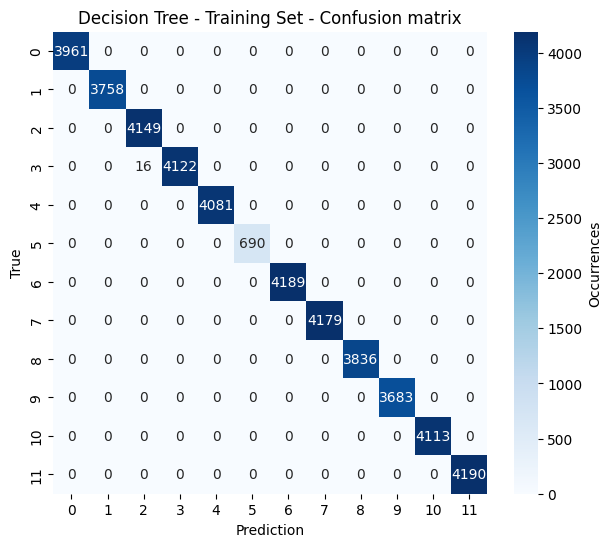

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       1.00      1.00      1.00      3758
           2       1.00      1.00      1.00      4149
           3       1.00      1.00      1.00      4138
           4       1.00      1.00      1.00      4081
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       1.00      1.00      1.00      4179
           8       1.00      1.00      1.00      3836
           9       1.00      1.00      1.00      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967


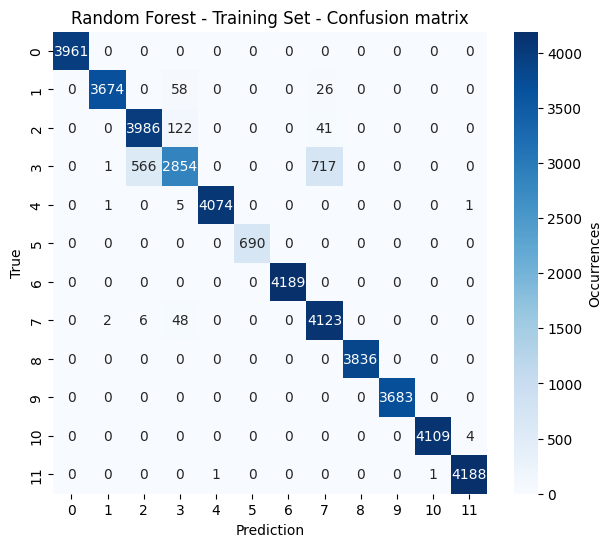

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3961
           1       1.00      0.98      0.99      3758
           2       0.87      0.96      0.92      4149
           3       0.92      0.69      0.79      4138
           4       1.00      1.00      1.00      4081
           5       1.00      1.00      1.00       690
           6       1.00      1.00      1.00      4189
           7       0.84      0.99      0.91      4179
           8       1.00      1.00      1.00      3836
           9       1.00      1.00      1.00      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           0.96     44967
   macro avg       0.97      0.97      0.97     44967
weighted avg       0.97      0.96      0.96     44967


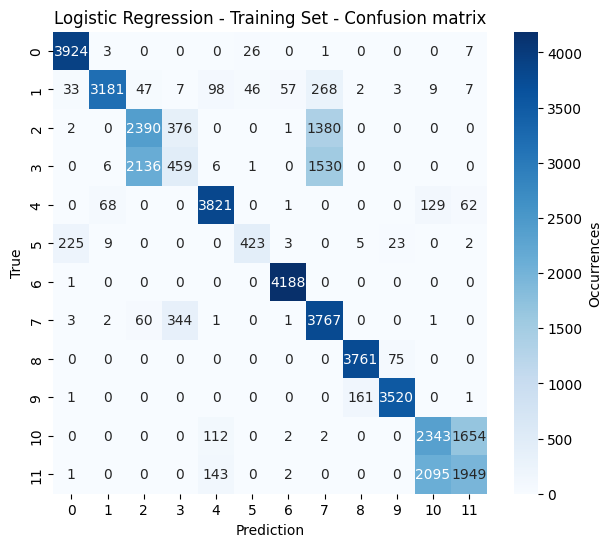

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3961
           1       0.97      0.85      0.91      3758
           2       0.52      0.58      0.54      4149
           3       0.39      0.11      0.17      4138
           4       0.91      0.94      0.92      4081
           5       0.85      0.61      0.71       690
           6       0.98      1.00      0.99      4189
           7       0.54      0.90      0.68      4179
           8       0.96      0.98      0.97      3836
           9       0.97      0.96      0.96      3683
          10       0.51      0.57      0.54      4113
          11       0.53      0.47      0.50      4190

    accuracy                           0.75     44967
   macro avg       0.76      0.75      0.74     44967
weighted avg       0.74      0.75      0.73     44967


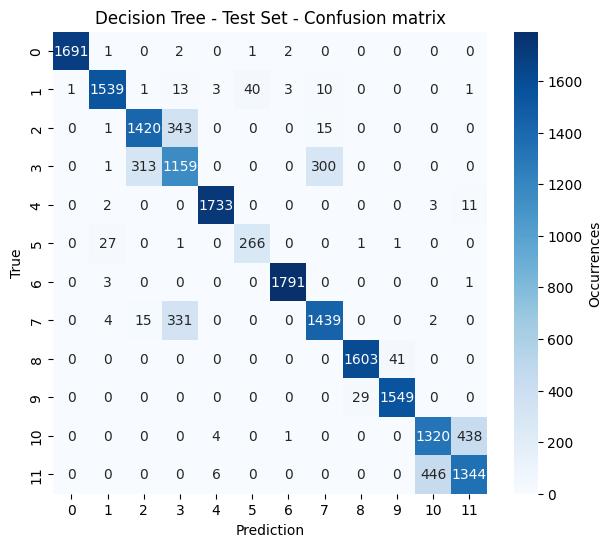

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1697
           1       0.98      0.96      0.97      1611
           2       0.81      0.80      0.80      1779
           3       0.63      0.65      0.64      1773
           4       0.99      0.99      0.99      1749
           5       0.87      0.90      0.88       296
           6       1.00      1.00      1.00      1795
           7       0.82      0.80      0.81      1791
           8       0.98      0.98      0.98      1644
           9       0.97      0.98      0.98      1578
          10       0.75      0.75      0.75      1763
          11       0.75      0.75      0.75      1796

    accuracy                           0.87     19272
   macro avg       0.88      0.88      0.88     19272
weighted avg       0.88      0.87      0.88     19272


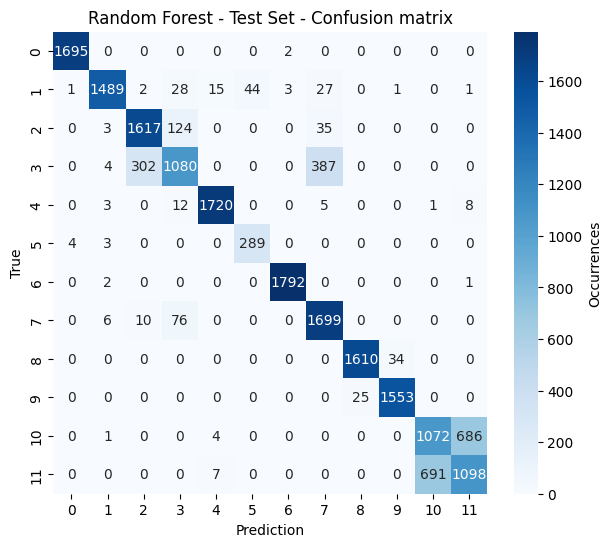

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1697
           1       0.99      0.92      0.95      1611
           2       0.84      0.91      0.87      1779
           3       0.82      0.61      0.70      1773
           4       0.99      0.98      0.98      1749
           5       0.87      0.98      0.92       296
           6       1.00      1.00      1.00      1795
           7       0.79      0.95      0.86      1791
           8       0.98      0.98      0.98      1644
           9       0.98      0.98      0.98      1578
          10       0.61      0.61      0.61      1763
          11       0.61      0.61      0.61      1796

    accuracy                           0.87     19272
   macro avg       0.87      0.88      0.87     19272
weighted avg       0.87      0.87      0.87     19272


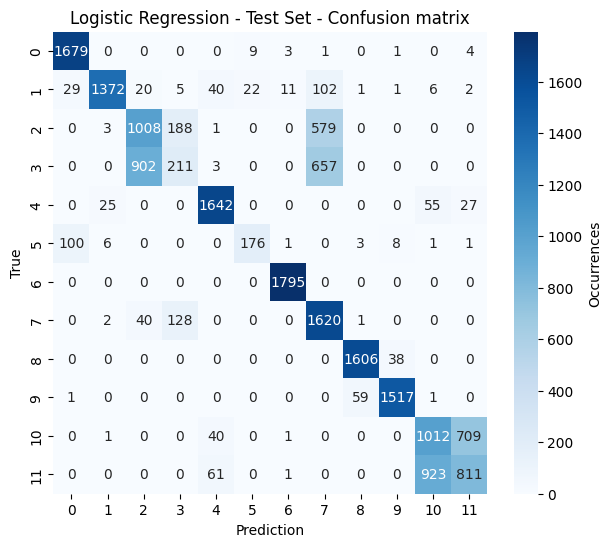

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1697
           1       0.97      0.85      0.91      1611
           2       0.51      0.57      0.54      1779
           3       0.40      0.12      0.18      1773
           4       0.92      0.94      0.93      1749
           5       0.85      0.59      0.70       296
           6       0.99      1.00      1.00      1795
           7       0.55      0.90      0.68      1791
           8       0.96      0.98      0.97      1644
           9       0.97      0.96      0.97      1578
          10       0.51      0.57      0.54      1763
          11       0.52      0.45      0.48      1796

    accuracy                           0.75     19272
   macro avg       0.76      0.74      0.74     19272
weighted avg       0.74      0.75      0.73     19272


In [51]:
# Output confusion matrices and classification reports

# Decision Tree - Training Set
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_train, y_train_pred_dt), cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Decision Tree - Training Set - Confusion matrix')
plt.show()
print(classification_report(y_train, y_train_pred_dt))

# Random Forest - Training Set
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_train, y_train_pred_rf), cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Random Forest - Training Set - Confusion matrix')
plt.show()
print(classification_report(y_train, y_train_pred_rf))

# Logistic Regression - Training Set
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_train, y_train_pred_lr), cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Logistic Regression - Training Set - Confusion matrix')
plt.show()
print(classification_report(y_train, y_train_pred_lr))

# Decision Tree - Test Set
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_dt), cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Decision Tree - Test Set - Confusion matrix')
plt.show()
print(classification_report(y_test, y_test_pred_dt))

# Random Forest - Test Set
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_rf), cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Random Forest - Test Set - Confusion matrix')
plt.show()
print(classification_report(y_test, y_test_pred_rf))

# Logistic Regression - Test Set
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_lr), cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Logistic Regression - Test Set - Confusion matrix')
plt.show()
print(classification_report(y_test, y_test_pred_lr))

# 3. Tune the hyper-parameters of the models through cross-validation. How do performance vary? Which model generates the best performance?

In [52]:
# find best hyper-parameters
X_s = x_train_s
y = y_train

# iterate over all possible combinations
best_combination = [0,1,2,3]
acc_max = 0
idx = -1
idx_best = idx
info_accuracy_train = []
info_accuracy_val = []

for criterion in ['gini', 'entropy']:
    for max_depth in [4, 6, 8, None]:
        for min_samples_split in [2, 3, 4]:
            idx += 1

            random_states = set()
            while len(random_states) < 5:
                n = random.randint(0,1000000)
                random_states.add(n)
        
            accuraries_train_tmp = []
            accuraries_val_tmp = []
            
            # iterate over all random states with same training size to derive the 10 different performance
            for random_state in random_states:
                # further split into training and validation
                X_train_s, X_val_s, y_train, y_val = train_test_split(
                    X_s, y, 
                    stratify = y, 
                    train_size = 0.5/0.7, 
                    random_state = random_state
                )

                # initialize and fit a model per combination of parameters
                dt_tmp = DecisionTreeClassifier(
                    criterion = criterion, 
                    max_depth = max_depth, 
                    min_samples_split = min_samples_split,
                    random_state = 0
                )
                dt_tmp.fit(X_train_s, y_train)
                accuraries_train_tmp.append(accuracy_score(y_train, dt_tmp.predict(X_train_s)))
                accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val_s)))
        
            # calculate the statistics to generate overall performance
            accuraries_tmp = np.array(accuraries_train_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_train.append((mean_acc, min_acc, max_acc))
            
            accuraries_tmp = np.array(accuraries_val_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_val.append((mean_acc, min_acc, max_acc))

            if mean_acc >= acc_max:
                idx_best = idx
                acc_max = mean_acc
                best_combination[0] = criterion
                best_combination[1] = max_depth
                best_combination[2] = min_samples_split

print('Best:')
print(
    f'criterion: {best_combination[0]}, ' + \
    f'max_depth: {best_combination[1]}, ' + \
    f'min_samples_split: {best_combination[2]}'
)

Best:
criterion: gini, max_depth: None, min_samples_split: 3


In [55]:
# test best model
dt_final = DecisionTreeClassifier(
    criterion = best_combination[0], 
    max_depth = best_combination[1], 
    min_samples_split = best_combination[2],
    max_features = best_combination[3],
    random_state = 0
)
dt_final.fit(X_s, y)
y_pred = dt_final.predict(x_test_s)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1697
           1       0.93      0.90      0.91      1611
           2       0.74      0.87      0.80      1779
           3       0.75      0.51      0.61      1773
           4       0.96      0.95      0.96      1749
           5       0.85      0.83      0.84       296
           6       1.00      1.00      1.00      1795
           7       0.77      0.90      0.83      1791
           8       0.95      0.96      0.96      1644
           9       0.96      0.95      0.95      1578
          10       0.57      0.58      0.57      1763
          11       0.58      0.58      0.58      1796

    accuracy                           0.83     19272
   macro avg       0.84      0.84      0.83     19272
weighted avg       0.83      0.83      0.83     19272


In [ ]:
# Decision Tree alternativa sfruttando funzioni: NON FUNZIONA PER ORA

# Definizione della griglia di iper-parametri da testare
param_grid_decision_tree = {
    'max_depth': [4,6,8,None],
    'min_samples_split': [2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Creazione dell'oggetto GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid_decision_tree, cv=5, scoring='accuracy')

# Esecuzione della grid search
grid_search.fit(x_train_s, y_train)

# Stampa dei migliori iper-parametri e della relativa accuratezza
print("Migliori iper-parametri:", grid_search.best_params_)
print("Migliore accuratezza:", grid_search.best_score_)

# Valutazione del modello ottimizzato sul set di test
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Accuratezza sul set di test:", test_accuracy)